## Data Loading and Initial Challenges
Initially, we faced a challenge fetching the dataset directly using the `ucimlrepo` library due to server-side connectivity issues.

To overcome this, we adopted an alternative approach by manually downloading the `chronic_kidney_disease_full.arff` file. We then implemented a custom parsing script, adapted from a solution on [Stack Overflow](https://stackoverflow.com/questions/62653514/open-an-arff-file-with-scipy-io/66939746#66939746), to load the data into a pandas DataFrame.

The script reads the .arff file line by line, skipping the header metadata and using a predefined list of column names to structure the data correctly. The code for this process is as follows:

In [875]:
import pandas as pd

data = []
with open('kidney/chronic_kidney_disease_full.arff', "r") as f:
    for line in f:
        line = line.replace('\n', '')
        data.append(line.split(','))


names = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba',
         'bgr', 'bu',  'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc',
         'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane',
         'class', 'no_name']

df = pd.DataFrame(data[145:], columns=names)
df.describe()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class,no_name
count,402,400,400,400,400,400,400,400,400,400,...,400,400,400,400,400,400,400,400,400,3
unique,78,11,6,7,7,3,3,3,3,147,...,93,50,3,7,4,4,4,3,4,2
top,60,80,1.020,0,0,normal,normal,notpresent,notpresent,?,...,?,?,no,no,no,good,no,no,ckd,
freq,19,116,106,199,290,201,259,354,374,44,...,105,130,251,257,362,316,322,339,248,2


## Feature Selection and Data Type Conversion

Our manual loading method didn't preserve the original data types, however, this was not a significant issue, as our plan from the start was to focus mainly on the numeric features for this analysis.

In [876]:
df.dtypes

age        object
bp         object
sg         object
al         object
su         object
rbc        object
pc         object
pcc        object
ba         object
bgr        object
bu         object
sc         object
sod        object
pot        object
hemo       object
pcv        object
wbcc       object
rbcc       object
htn        object
dm         object
cad        object
appet      object
pe         object
ane        object
class      object
no_name    object
dtype: object


First, we will drop the categorical columns that aren't needed for this analysis. Then, we'll convert the remaining columns using the to_numeric function in pandas. We use the errors='coerce' setting, which is very helpful because it automatically turns any value that can't be converted (like a leftover symbol or text) into NaN (Not a Number). This makes the entire dataset consistent and easier to clean in the next steps.

#### 1. Feature Selection: Drop unnecessary categorical and identifier columns

In [877]:
df = df.drop(columns=[
    'no_name', 'rbc', 'pc', 'pcc', 'ba',
    'sc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'
])

#### 2. Data Type Conversion: Define which columns should be numeric

In [878]:
numeric_cols = ['age', 'bp', 'sg', 'al', 'su',
                'bgr', 'bu', 'sod', 'pot', 'hemo',
                'pcv', 'wbcc', 'rbcc']

# Loop through the list and convert each column
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

#### 3. Verification: Display the final data types to confirm the conversion

In [879]:
df.dtypes

age      float64
bp       float64
sg       float64
al       float64
su       float64
bgr      float64
bu       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
class     object
dtype: object

## Data cleaning

After loading and formatting the data, the next critical phase is data cleaning. The primary goals for this stage are to handle the missing values, simplify the class column for modeling, and identify any potential outliers that could affect the results.

Our cleaning process consists of the following steps:
#### 1. Standardize Missing Values
Ensure all placeholders are consistently represented as `NaN`.

In [880]:
# Note: pd.to_numeric with errors='coerce' already handled most of this.
# This is an extra step to ensure consistency.
df = df.replace(['?', 'None'], pd.NA)

#### 2. Handle Rows with Missing Data:
Remove rows that have an excessive number of missing values (3 or more), as they are unlikely to be useful.

In [881]:
df = df.dropna(thresh=len(df.columns)-2)
df = df.reset_index(drop=True)

#### 3. Impute Remaining Missing Values:
Fill the few remaining NaNs in the numeric columns. We will use the mean of each column for this.

In [882]:
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].mean()).round(3)

#### 4. Encode the Target Variable:
Simplify the class column into two distinct categories for our analysis.

In [883]:
#Changing ckd --> a (affected), notckd && no --> c (control)
df['class'] = df['class'].replace({'ckd': 'a', 'notckd': 'c', 'no': 'c'})

#### 5. Verify that there are no missing values left

In [884]:
print("\nTotal missing values per column after cleaning:\n")
print(df.isnull().sum())


Total missing values per column after cleaning:

age      0
bp       0
sg       0
al       0
su       0
bgr      0
bu       0
sod      0
pot      0
hemo     0
pcv      0
wbcc     0
rbcc     0
class    0
dtype: int64


In [885]:
print("\nDataFrame after cleaning and imputation:\n")
display(df.head())


DataFrame after cleaning and imputation:



,age,bp,sg,al,su,bgr,bu,sod,pot,hemo,pcv,wbcc,rbcc,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,138.193,4.52,15.4,44.0,7800.000,5.200,a
1,48.0,70.0,1.005,4.0,0.0,117.0,56.0,111.000,2.50,11.2,32.0,6700.000,3.900,a
2,51.0,80.0,1.010,2.0,0.0,106.0,26.0,138.193,4.52,11.6,35.0,7300.000,4.600,a
3,60.0,90.0,1.015,3.0,0.0,74.0,25.0,142.000,3.20,12.2,39.0,7800.000,4.400,a
4,68.0,70.0,1.010,0.0,0.0,100.0,54.0,104.000,4.00,12.4,36.0,8498.795,4.759,a


## Final Data Preparation for Analysis

With the data now cleaned and validated, we perform the final preparation steps required by the assignment. This involves a unit conversion for the hemoglobin feature, renaming the columns for better readability, removing all underage persons and finally splitting the dataset into two groups—affected patients and a control group—for comparative analysis.

#### 1. Hemoglobin Unit Conversion
The original dataset measures hemoglobin in grams per deciliter (g/dl). The assignment requires this to be in grams per liter (g/l). We perform this conversion by multiplying the entire hemoglobin column by 10.

In [886]:
df['hemo'] = pd.to_numeric(df['hemo'], errors='coerce') * 10

print("Hemoglobin values after converting to g/l:")
display(df[['hemo']].head(3))

Hemoglobin values after converting to g/l:


,hemo
0,154.0
1,112.0
2,116.0


#### 2. Removing Underaged Patients from the Data
To ensure our analysis is ethical and appropriate, we will filter the dataset to include only records for patients aged 18 and over.

In [887]:
# Using .copy() is good practice to ensure we're working with a new, independent DataFrame
df= df[df['age'] >= 18].copy()

#### 3. Renaming Columns for Clarity
As an important step for readability, especially for the upcoming graphs and analysis, we first convert the abbreviated column names into more descriptive ones.

In [888]:
column_name_map = {
    'age': 'age',
    'bp': 'blood_pressure',
    'sg': 'specific_gravity',
    'al': 'albumin',
    'su': 'sugar',
    'bgr': 'blood_glucose_random',
    'bu': 'blood_urea',
    'sod': 'sodium',
    'pot': 'potassium',
    'hemo': 'hemoglobin',
    'pcv': 'packed_cell_volume',
    'wbcc': 'white_blood_cell_count',
    'rbcc': 'red_blood_cell_count',
    'class': 'class'
}
df_renamed = df.rename(columns=column_name_map)

display(df_renamed.head(3))

,age,blood_pressure,specific_gravity,albumin,sugar,blood_glucose_random,blood_urea,sodium,potassium,hemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,138.193,4.52,154.0,44.0,7800.0,5.2,a
1,48.0,70.0,1.005,4.0,0.0,117.0,56.0,111.000,2.50,112.0,32.0,6700.0,3.9,a
2,51.0,80.0,1.010,2.0,0.0,106.0,26.0,138.193,4.52,116.0,35.0,7300.0,4.6,a


#### 4. Splitting Dataframe by Class
To analyze the differences between patients with Chronic Kidney Disease and the control group, we now split the main DataFrame into two separate ones based on the 'class' column: df_a for affected patients and df_c for the control group.

In [889]:
# Using .copy() is a good practice to prevent potential warnings from pandas
df_a = df_renamed[df_renamed['class'] == 'a'].copy()
df_c = df_renamed[df_renamed['class'] == 'c'].copy()

# Verify the split by printing the number of rows in each new DataFrame
print(f"\nNumber of rows in Affected group (df_a): {df_a.shape[0]}")
print(f"Number of rows in Control group (df_c): {df_c.shape[0]}")


Number of rows in Affected group (df_a): 121
Number of rows in Control group (df_c): 136


#### 5. Comparing Group Statistics
Finally, we generate descriptive statistics for both groups. This gives us an initial quantitative overview of their characteristics and allows us to see potential differences at a glance.

In [890]:
# Generate and display statistics for the 'affected' group
print("\n--- Statistics for Affected Group (a) ---")
display(df_a.describe().T)

# Generate and display statistics for the 'control' group
print("\n--- Statistics for Control Group (c) ---")
display(df_c.describe().T)

# Using .T (transpose) to make the table easier to read if there are many columns


--- Statistics for Affected Group (a) ---


,count,mean,std,min,25%,50%,75%,max
age,121.0,58.731504,11.489795,21.000,51.504,60.000,65.000,90.000
blood_pressure,121.0,81.322314,15.649396,50.000,70.000,80.000,90.000,180.000
specific_gravity,121.0,1.013579,0.004555,1.005,1.010,1.015,1.015,1.025
albumin,121.0,1.859504,1.427736,0.000,1.000,2.000,3.000,5.000
sugar,121.0,0.842975,1.384487,0.000,0.000,0.000,2.000,5.000
blood_glucose_random,121.0,182.733322,91.297155,70.000,115.000,156.000,241.000,490.000
blood_urea,121.0,82.460603,60.324420,15.000,40.000,60.000,107.000,322.000
sodium,121.0,134.169207,7.310950,104.000,132.000,136.000,138.193,145.000
potassium,121.0,4.747603,3.965128,2.500,3.900,4.400,4.800,47.000
hemoglobin,121.0,105.885950,21.777677,31.000,95.000,108.000,120.000,161.000



--- Statistics for Control Group (c) ---


,count,mean,std,min,25%,50%,75%,max
age,136.0,47.272059,15.340803,19.000,34.750,47.00,58.000,80.000
blood_pressure,136.0,71.335324,8.487388,60.000,60.000,70.00,80.000,80.000
specific_gravity,136.0,1.022463,0.002509,1.020,1.020,1.02,1.025,1.025
albumin,136.0,0.000000,0.000000,0.000,0.000,0.00,0.000,0.000
sugar,136.0,0.000000,0.000000,0.000,0.000,0.00,0.000,0.000
blood_glucose_random,136.0,108.518294,19.521064,70.000,93.750,109.00,125.000,142.122
blood_urea,136.0,33.587735,11.893097,10.000,24.000,33.50,45.000,55.733
sodium,136.0,141.783669,4.743116,135.000,138.000,141.00,146.000,150.000
potassium,136.0,4.337941,0.593791,3.300,3.700,4.51,4.900,5.000
hemoglobin,136.0,151.480882,13.051133,130.000,140.000,150.00,161.250,178.000


#### 6. Extreme values removal
After reviewing the descriptive statistics for both the affected (a) and control (c) groups, we perform a final data integrity check. The goal is to identify and correct values that are clear data entry errors.

In [891]:
# For any row where 'potassium' is > 10, divide the value in that cell by 10
df_a.loc[df_a['potassium'] > 10, 'potassium'] /= 10

## Graphics and analysis

Now that the data is cleaned and split into two groups ('affected' and 'control'), we can visualize the distribution of the numeric features. Using histograms allows us to visually inspect the shape, center, and spread of the data for each group. This process is crucial for identifying key differences between the health metrics of the two populations.


In [892]:
#Funktio histogrammin tekemiseen

def plot_data(df):
    numeric_cols = df.select_dtypes(include=['int', 'float']).columns
    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    plt.figure(figsize=(20, 5 * n_rows))

    for i, col in enumerate(numeric_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        df[col].plot(kind='hist', title=col)
        plt.xlabel(col)

    plt.tight_layout()
    plt.show()

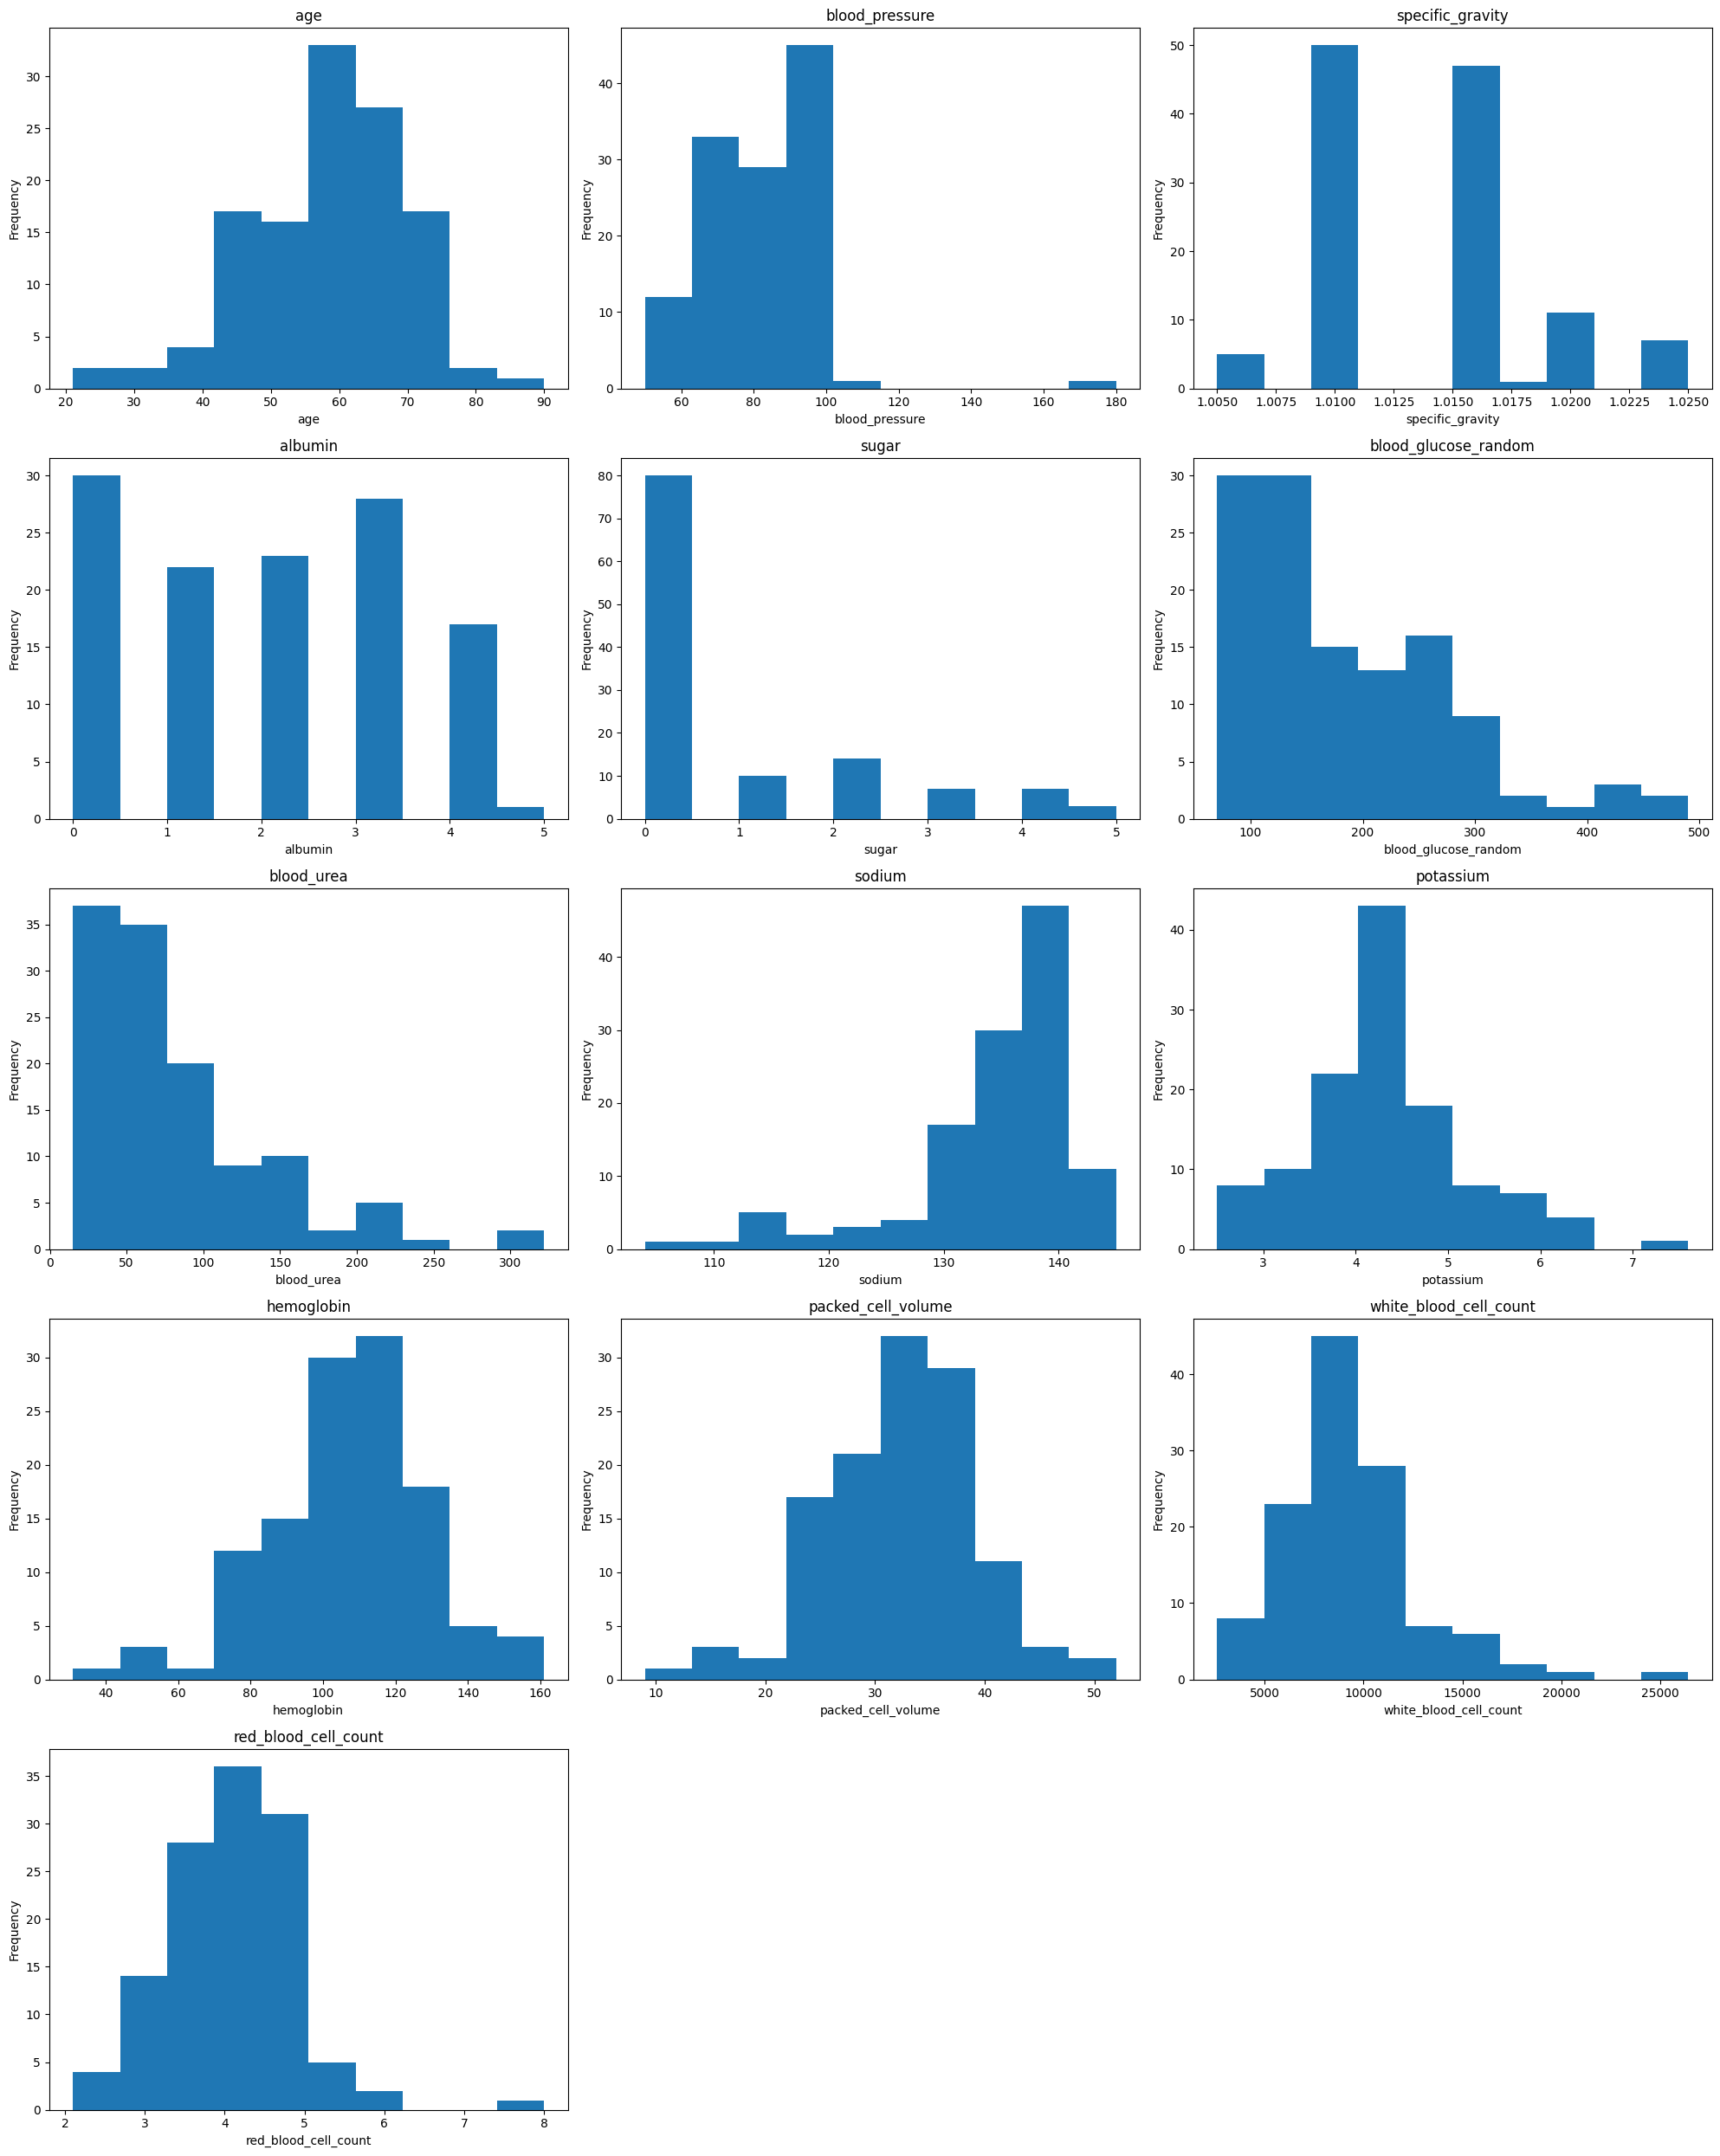

In [893]:
# Dataframe "a" histogram
plot_data(df_a)

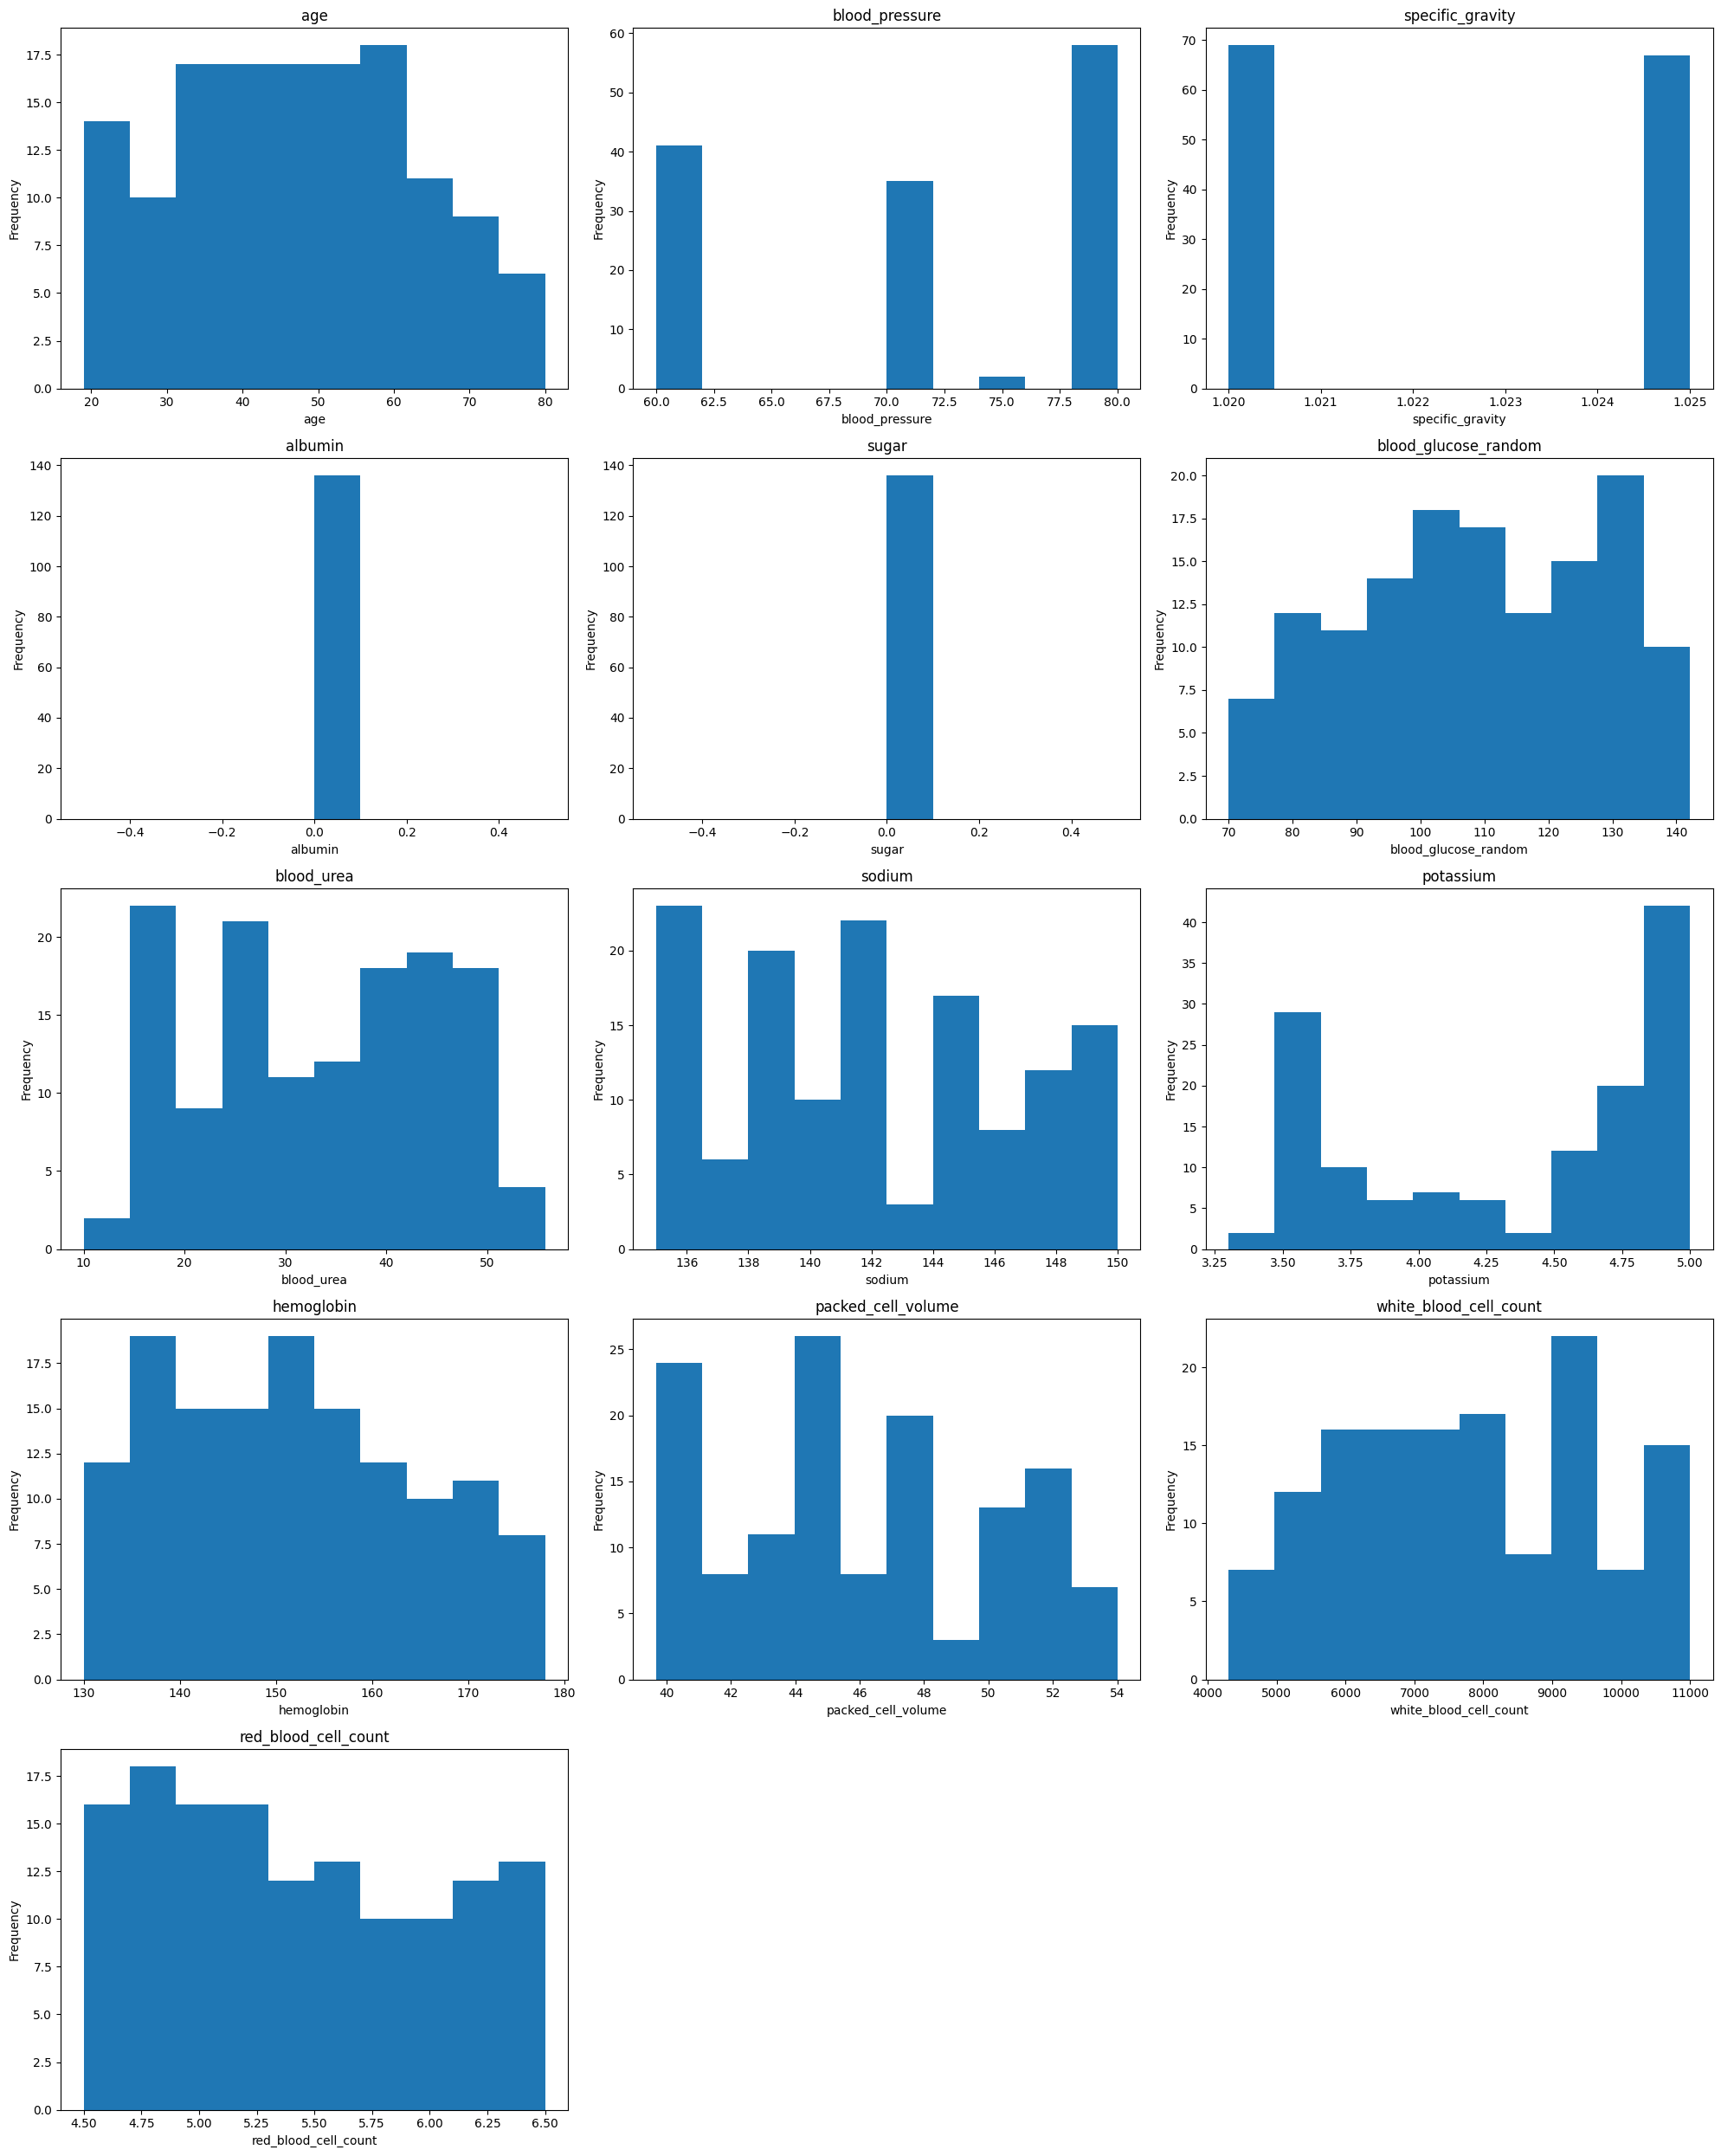

In [894]:
# Dataframe "c" histogram
plot_data(df_c)


### Summary for histograms
The distributions for the Control Group (c) are, for the most part, symmetrical with a "normal" range of values. This is consistent with what we would expect from a healthy population, where key health metrics fall within a standard, normal range.

In contrast, the histograms for the Affected Group (a) show significant deviations. Many of their distributions are wider and heavily skewed, indicating a much greater variance and the presence of extreme values. Such as: critically low hemoglobin levels are present or blood glucose random representing extremely high readings.

From a purely statistical perspective, these are outliers. However, in a medical context, they are identified by AI *"as plausible symptoms of severe chronic kidney disease and its common comorbidities (like anemia, diabetes, and hypertension)"*. To definitively classify these points, one would need clinical expertise, which would possibly be available in a real-world research scenario.

Therefore, for the purpose of this assignment, we will proceed with the assumption that these extreme values are not errors, but are instead valid data that characterize the severity of the condition in the affected population.

## Matrix

A correlation matrix is a powerful tool to understand the relationships between different attributes. It calculates a correlation coefficient for every pair of numeric variables, showing us how strongly they tend to move together.

In [900]:
# Function for correlation matrix and heatmap

def plot_correlation_matrix_matplotlib(df, title):
    numeric_cols = df.select_dtypes(include=['int', 'float']).columns
    corr = df[numeric_cols].corr()
    print(f"Correlation matrix for {title}:\n", corr)

    plt.figure(figsize=(10, 10))
    plt.imshow(corr, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    plt.xticks(range(len(corr)), corr.columns, rotation=90)
    plt.yticks(range(len(corr)), corr.columns)
    plt.title(f'Correlation matrix heatmap for {title}')
    plt.show()

Correlation matrix for Dataframe (a):
                              age  blood_pressure  specific_gravity   albumin  \
age                     1.000000       -0.076333         -0.000825 -0.036102   
blood_pressure         -0.076333        1.000000          0.108428  0.030762   
specific_gravity       -0.000825        0.108428          1.000000 -0.077099   
albumin                -0.036102        0.030762         -0.077099  1.000000   
sugar                   0.088735        0.163511         -0.023798  0.115221   
blood_glucose_random    0.117927       -0.004520         -0.075468  0.088989   
blood_urea             -0.115265        0.035188         -0.031495  0.429774   
sodium                  0.069256        0.172388          0.132212 -0.208848   
potassium               0.087011        0.056859          0.087342  0.176602   
hemoglobin              0.129528       -0.095062          0.110676 -0.355747   
packed_cell_volume      0.101877       -0.089536          0.113682 -0.308507   
w

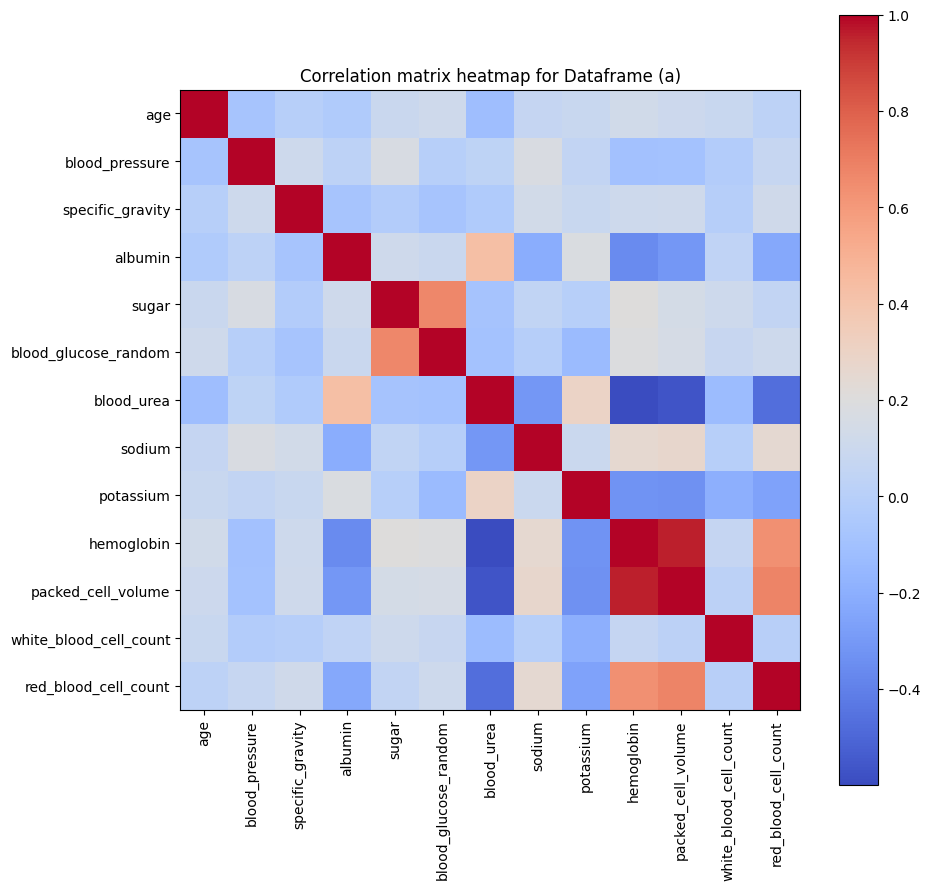

In [896]:
# Dataframe "a" correlation matrix ja heatmap
plot_correlation_matrix_matplotlib(df_a, "Dataframe (a)")

Correlation matrix for Dataframe (c):
                              age  blood_pressure  specific_gravity  albumin  \
age                     1.000000       -0.063810         -0.084898      NaN   
blood_pressure         -0.063810        1.000000          0.087891      NaN   
specific_gravity       -0.084898        0.087891          1.000000      NaN   
albumin                      NaN             NaN               NaN      NaN   
sugar                        NaN             NaN               NaN      NaN   
blood_glucose_random    0.098567       -0.028238         -0.009346      NaN   
blood_urea              0.071755       -0.082387         -0.023806      NaN   
sodium                  0.057025       -0.100266         -0.016535      NaN   
potassium              -0.092851       -0.044841          0.071547      NaN   
hemoglobin              0.106693        0.126420          0.050651      NaN   
packed_cell_volume      0.049747       -0.017075         -0.006164      NaN   
white_blood_c

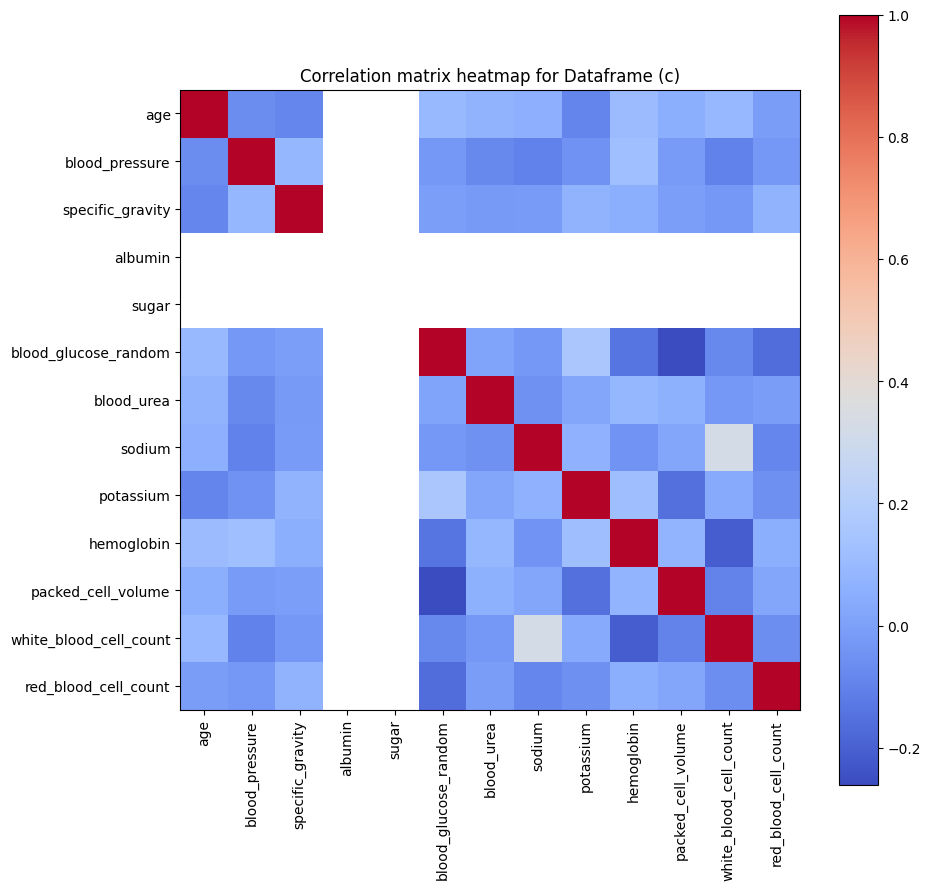

In [897]:
# Dataframe "c" correlation matrix ja heatmap
plot_correlation_matrix_matplotlib(df_c, "Dataframe (c)")

## Summary

Healthy group shows up in a calm blue tone, with no strong internal correlations.
Affected group, however, is much more colorful, with a few clear contrasts: glucose tracks with sugar level, and red blood cell count aligns with hemoglobin.

This makes sense — glucose is sugar, and hemoglobin lives inside red blood cells. So the picture is logical, but also rather basic: the correlations confirm fundamentals rather than revealing new insights.

## AI generated bonus visuals :D

--- Starting Outlier Analysis for: Affected Group (a) ---

Analyzing Feature: 'age'
Found 3 outliers in 'age':


,age
38,26.0
90,21.0
102,90.0


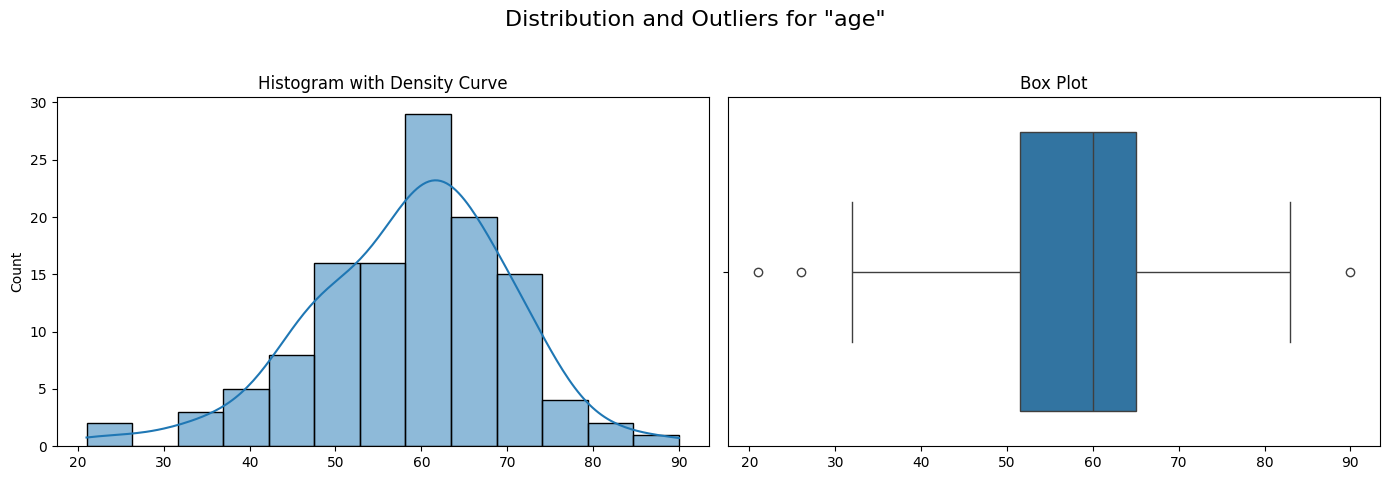


Analyzing Feature: 'blood_pressure'
Found 1 outliers in 'blood_pressure':


,blood_pressure
55,180.0


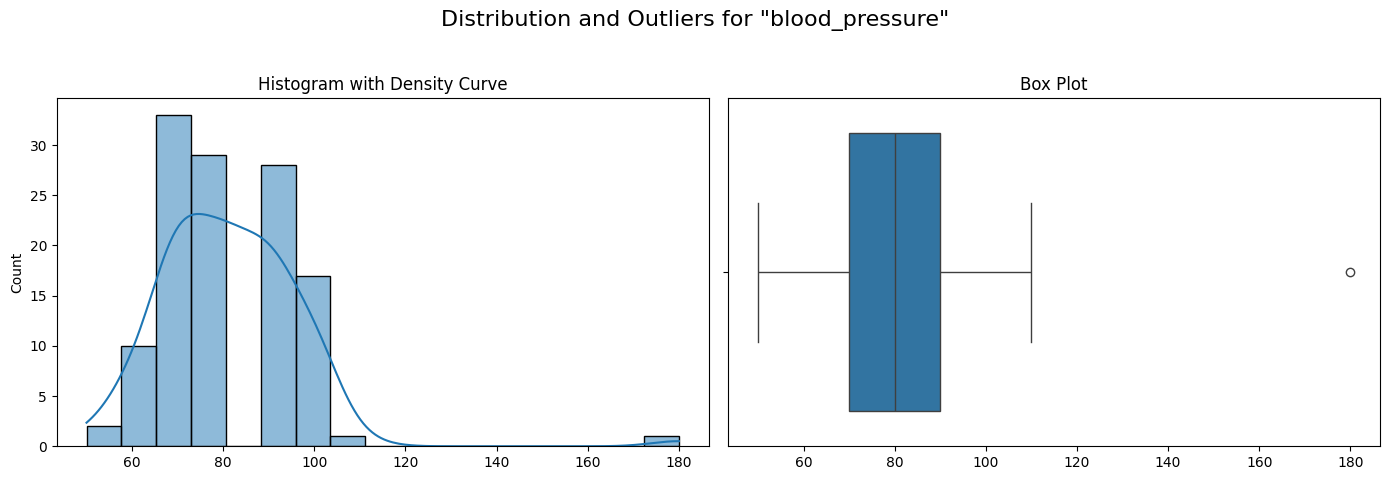


Analyzing Feature: 'specific_gravity'
Found 7 outliers in 'specific_gravity':


,specific_gravity
11,1.025
14,1.025
16,1.025
80,1.025
92,1.025
98,1.025
102,1.025


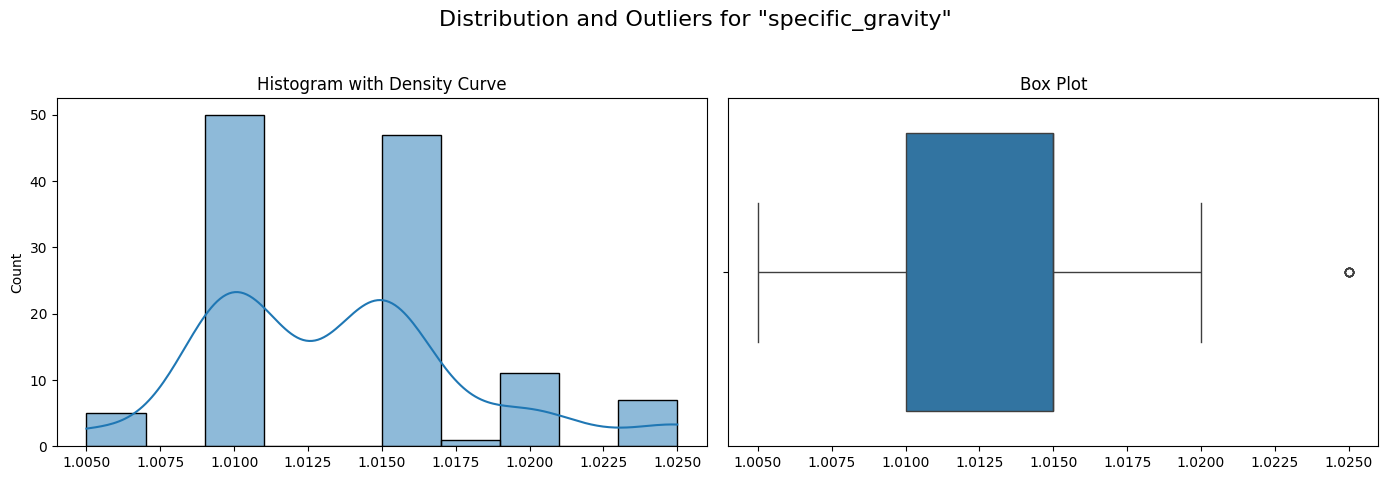


Analyzing Feature: 'albumin'
No outliers detected in 'albumin' using the IQR method.


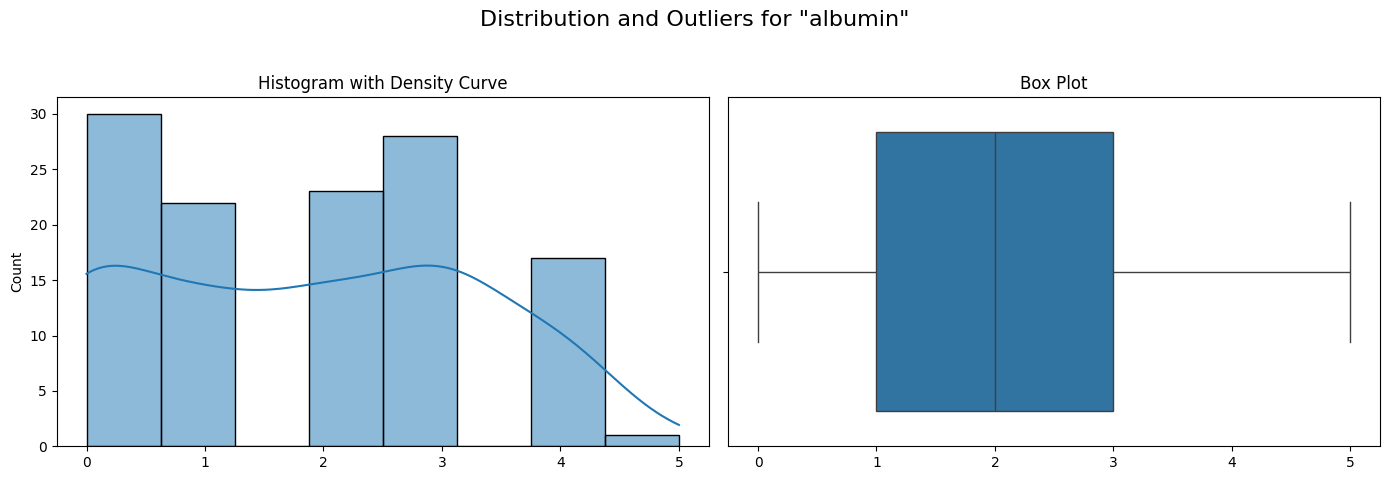


Analyzing Feature: 'sugar'
No outliers detected in 'sugar' using the IQR method.


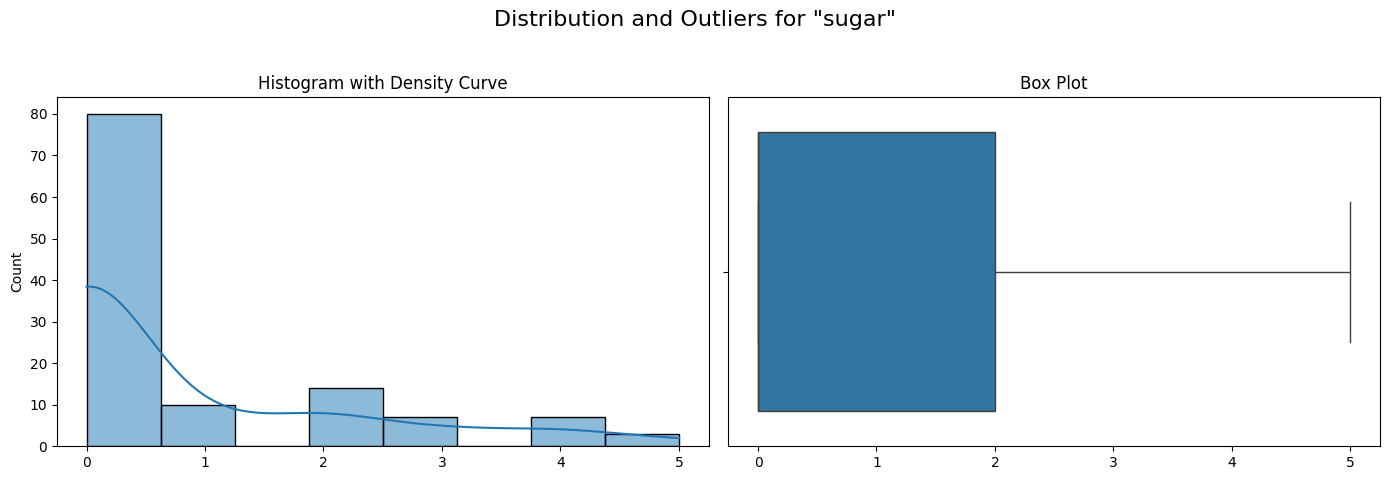


Analyzing Feature: 'blood_glucose_random'
Found 3 outliers in 'blood_glucose_random':


,blood_glucose_random
85,447.0
113,490.0
122,463.0


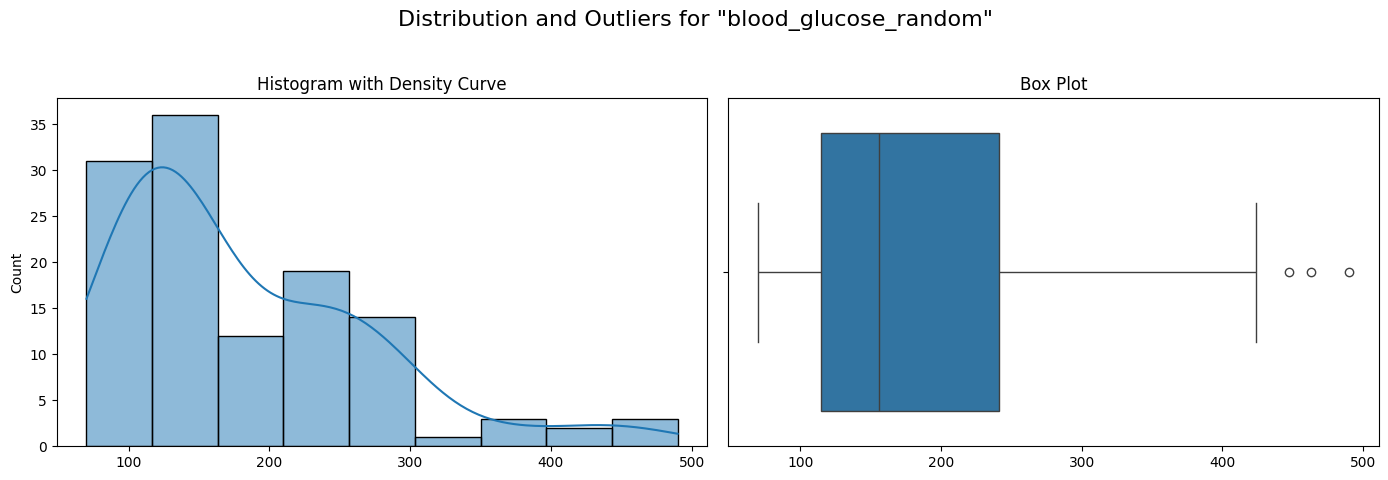


Analyzing Feature: 'blood_urea'
Found 7 outliers in 'blood_urea':


,blood_urea
58,217.0
69,208.0
75,322.0
78,235.0
98,223.0
123,215.0
125,309.0


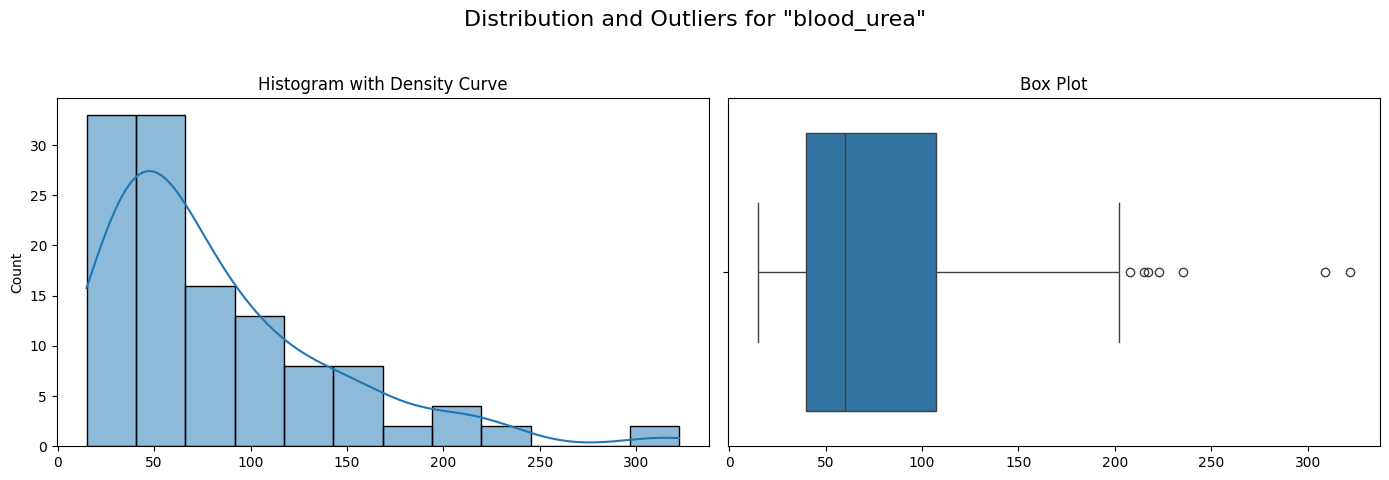


Analyzing Feature: 'sodium'
Found 11 outliers in 'sodium':


,sodium
1,111.0
4,104.0
6,114.0
82,122.0
86,115.0
89,113.0
98,113.0
99,122.0
116,114.0
120,120.0


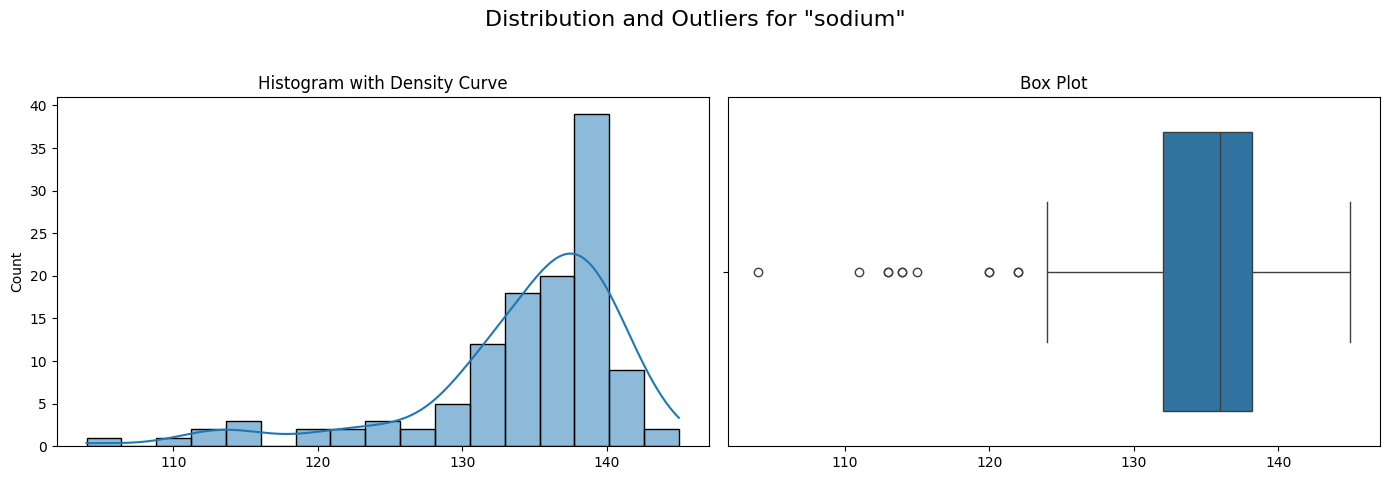


Analyzing Feature: 'potassium'
Found 7 outliers in 'potassium':


,potassium
1,2.5
9,6.4
47,7.6
87,2.5
98,6.5
103,6.3
125,6.5


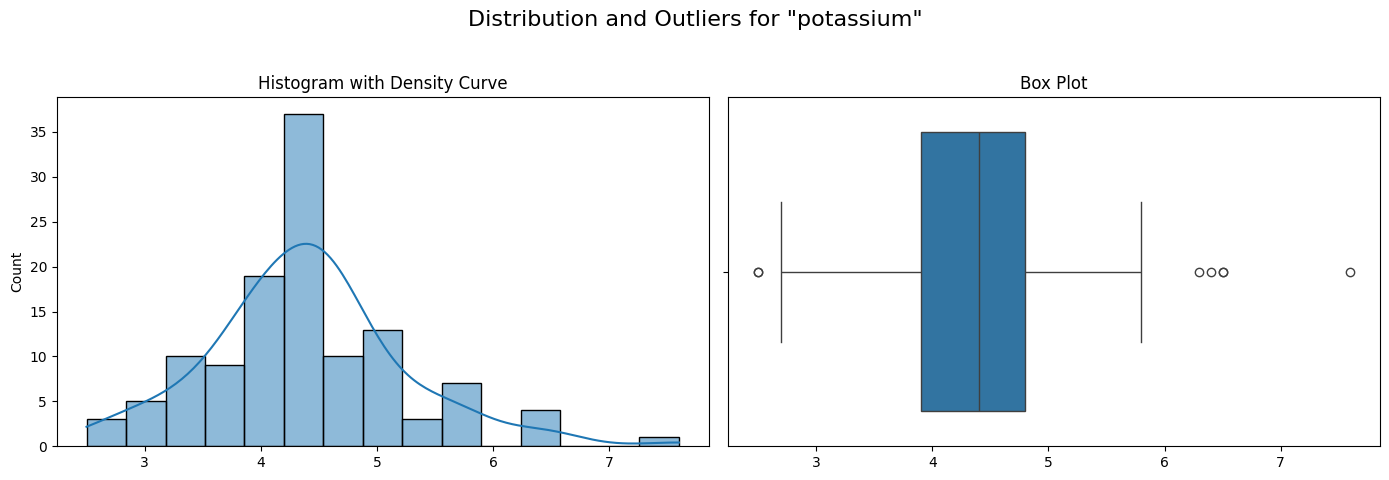


Analyzing Feature: 'hemoglobin'
Found 5 outliers in 'hemoglobin':


,hemoglobin
9,56.0
41,48.0
50,161.0
98,55.0
125,31.0


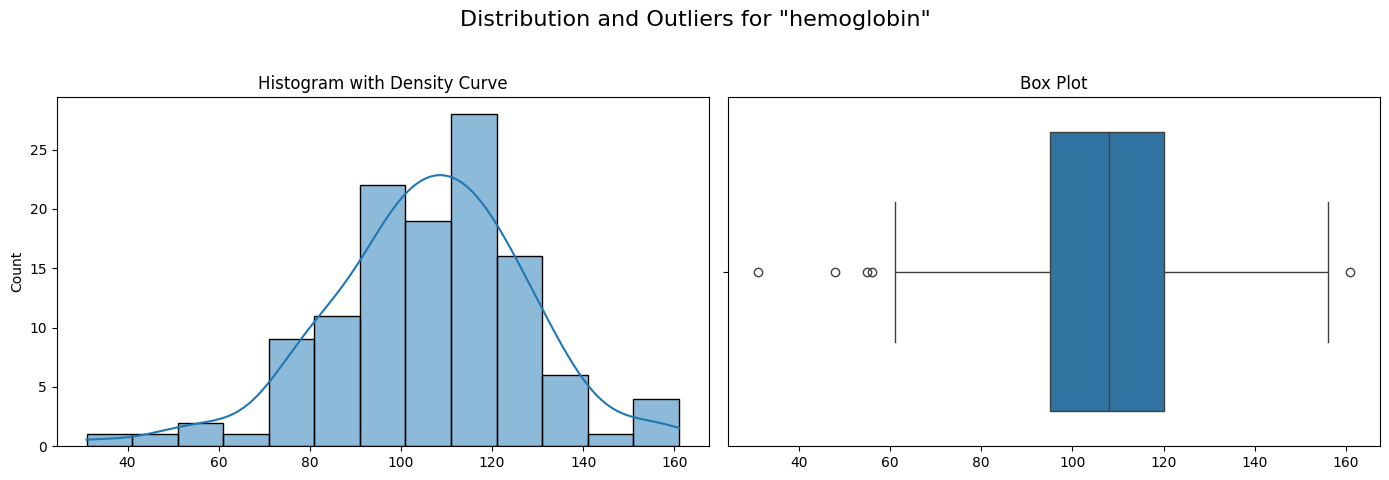


Analyzing Feature: 'packed_cell_volume'
Found 4 outliers in 'packed_cell_volume':


,packed_cell_volume
38,52.0
41,14.0
50,52.0
125,9.0


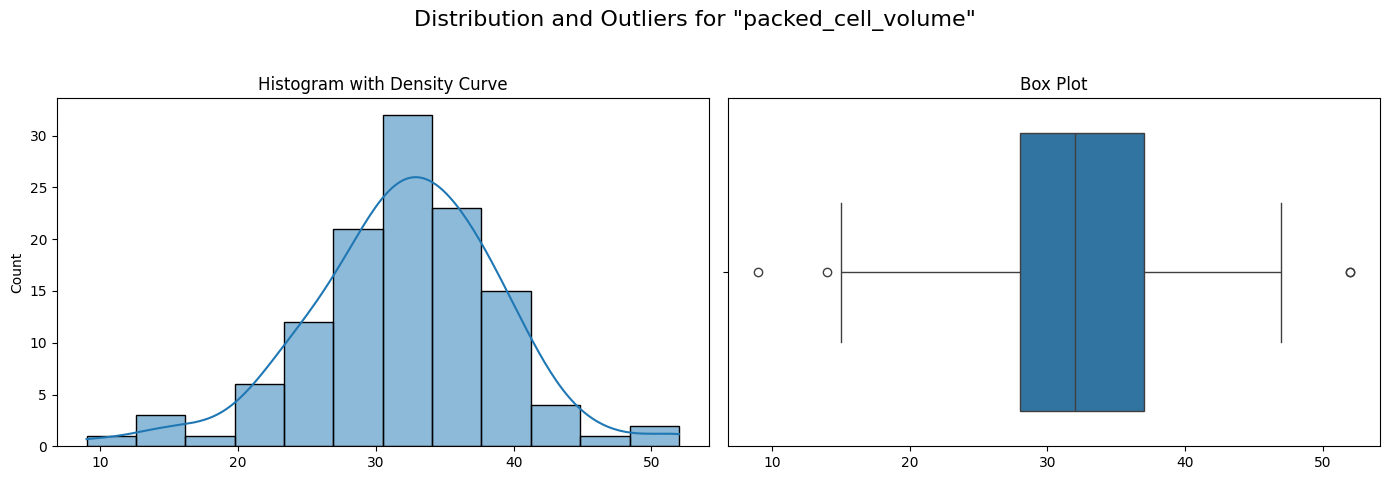


Analyzing Feature: 'white_blood_cell_count'
Found 6 outliers in 'white_blood_cell_count':


,white_blood_cell_count
29,18900.0
30,21600.0
69,16300.0
92,19100.0
100,26400.0
116,15700.0


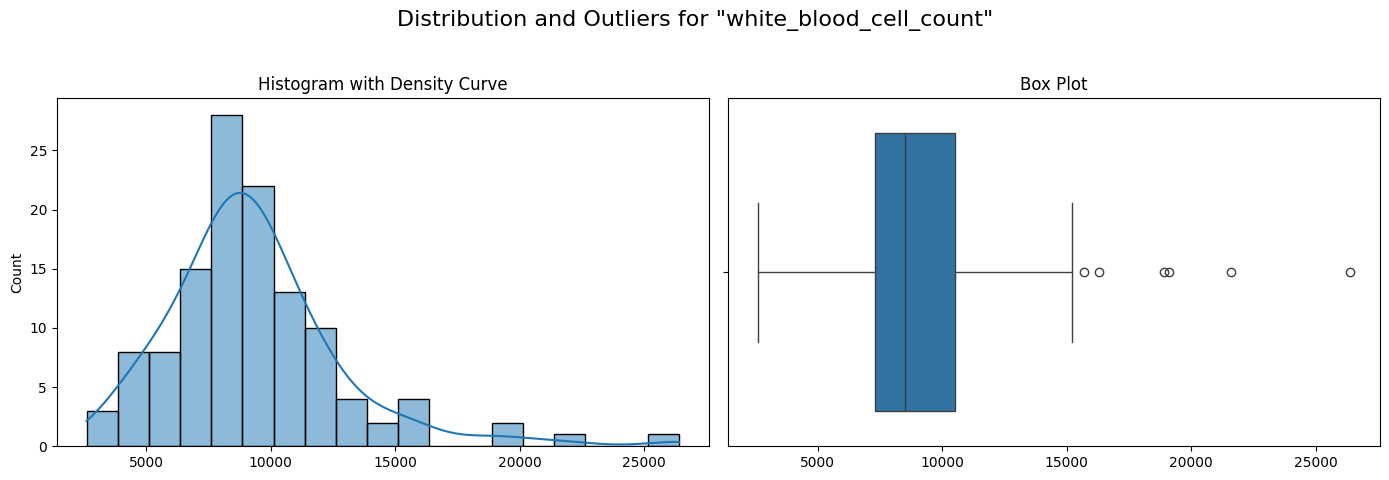


Analyzing Feature: 'red_blood_cell_count'
Found 1 outliers in 'red_blood_cell_count':


,red_blood_cell_count
70,8.0


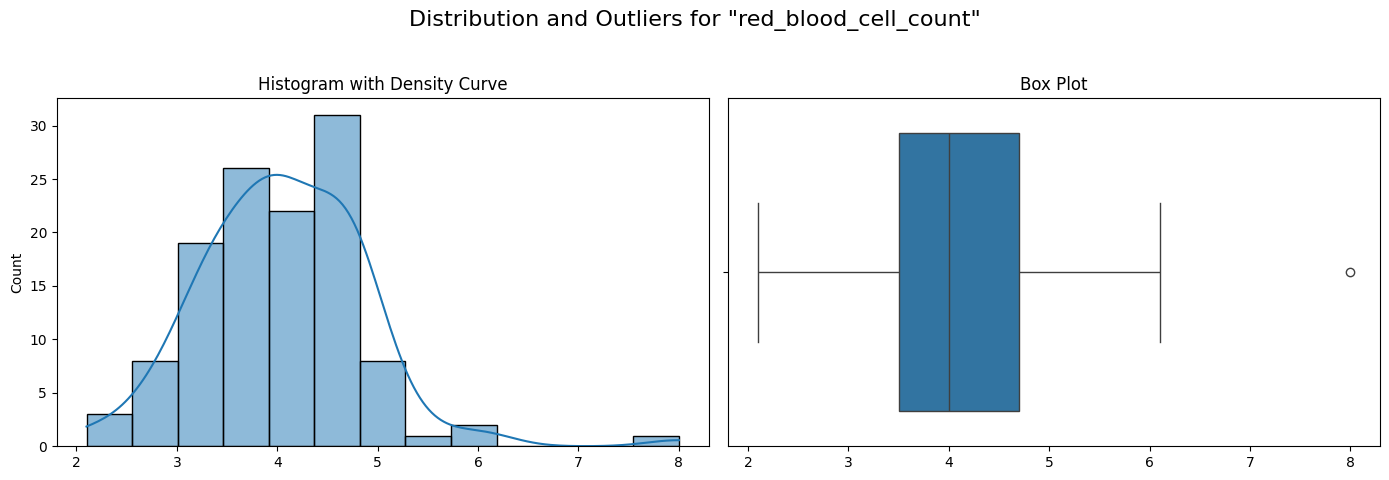

In [671]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_outliers(df, df_name='DataFrame'):
    """
    Analyzes each numeric column in a DataFrame for outliers.

    For each column, it prints the outliers found using the IQR method
    and displays a histogram and a box plot.
    """
    # Select only the numeric columns from the DataFrame
    numeric_cols = df.select_dtypes(include=np.number).columns

    print(f"--- Starting Outlier Analysis for: {df_name} ---")

    # Loop through each numeric column
    for col in numeric_cols:
        print(f"\n==================================================")
        print(f"Analyzing Feature: '{col}'")
        print(f"==================================================")

        # 1. CALCULATE AND PRINT OUTLIERS using the IQR method
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        if not outliers.empty:
            print(f"Found {len(outliers)} outliers in '{col}':")
            display(outliers[[col]])
        else:
            print(f"No outliers detected in '{col}' using the IQR method.")

        # 2. DISPLAY VISUALIZATIONS (Histogram and Box Plot)
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        fig.suptitle(f'Distribution and Outliers for "{col}"', fontsize=16)

        # Plot 1: Histogram with a density curve
        sns.histplot(df[col], kde=True, ax=axes[0])
        axes[0].set_title('Histogram with Density Curve')
        axes[0].set_xlabel('')

        # Plot 2: Box Plot
        sns.boxplot(x=df[col], ax=axes[1])
        axes[1].set_title('Box Plot')
        axes[1].set_xlabel('')

        # Show the plots
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Run the complete outlier analysis on the 'affected' group DataFrame
analyze_outliers(df_a, df_name='Affected Group (a)')
# analyze_outliers(df_c, df_name='Control Group (c)')